# Homework Set 3

In [1]:
%pylab inline
import pandas as pd
import numpy as np

import fmt

Populating the interactive namespace from numpy and matplotlib


#### Unless explicitly forbidden, you can use any python functions from numpy/scipy to solve homework problems.

## Problem 1
$\renewcommand{bs}{\boldsymbol}$

We discussed three different ways of solving the least square problem of $\min_{\boldsymbol \beta}\Vert X \bs \beta - \boldsymbol y\Vert_2$ in the lecture: 1) the pseudo-inverse $X^+$ 2) QR decomposition 3) SVD. 

1. if $X$ is not fully ranked, i.e., its column vectors are linearly dependent, do the three methods still work?
2. if not, can you propose an modifications to the QR method, so that you can find the minimum value of $\Vert X \bs \beta - \boldsymbol y\Vert_2$ even when $X$ is rank deficient? Note that $\bs \beta$ is not unique when $X$ is not fully ranked, but there is still a deterministic answer to the minimum value of $\Vert X \bs \beta - \boldsymbol y\Vert_2$. 
3. what is an easy and effective method to find a $\bs \beta$ that is good enough when $X$ is not fully ranked in practice?

Hint:
- It is also possible to make SVD work with rank deficient matrix. Please refer to http://www.cs.cornell.edu/Courses/cs3220/2010sp/notes/svd.pdf if you are interested.

### Solution

1. No, they do not work with rank deficient $A$.
2. if $X$ is not fully ranked, then after QR decomposition of $X = Q R$, the square portion of $R$ will not be invertible. In this case, the $\bs \beta$ is not unique; but we can still compute the minimal $\Vert X \bs \beta - \bs y\Vert_2$ by checking how many rows we cannot zero out in the $Q^T \bs y$ vector, and the minimal is the L-2 norm of all the rows that can't be zero out.
3. a better method is to use Ridge regression with a small $\lambda$, which works well in practice for rank deficient $X$.

The following problems use the same CMT treasury data set from the class:

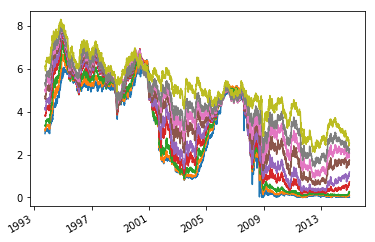

In [2]:
cmturl = "https://raw.githubusercontent.com/yadongli/nyumath2048/master/data/cmt.csv"
cmt_rates = pd.read_csv(cmturl, parse_dates=[0], index_col=[0])

cmt_rates.plot(legend=False);
tenors = cmt_rates.columns.map(float)
tenorTags = ['T=%g' % m for m in tenors]

##　Problem 2

Take the covariance matrix $V$ estimated from the CMT historical levels, compute the following:
1. its L-2 condition number
2. its singular values, and the ratio between the largest and smallest singular values
3. Comment on whether there could be troubled area when computing $\bs y = V^{-1} \bs x$ from this co-variance matrix, if so, give an example of $\bs x$ that the resulting $\bs y$ changes a lot even with a small perturbations in $x$.

### Solution

The condition number is very large. The troubled area is around the eigen vectors corresponds to the largest eigen values of $V$, which are those corresponds to the smallest eigen values of $V^{-1}$. The lesson here is that it is very common to run into covariance matrix in real world data that are near singular (i.e., has very large condition number), and to work with these matrix, we need to avoid the troubled spots, which can be identified by SVD analysis.

In [3]:
cov = cmt_rates.cov()
l2 = np.linalg.cond(cov, 2)

print("L2 norm ", l2)

u, s, v = np.linalg.svd(cov)
print("singular value ratios ", s[0]/s[-1])

L2 norm  74717.1109669
singular value ratios  74717.1109669


The following is an example of troubled spot where the output changes a lot even with small perturbation of inputs. The trouble spots are to the direction of the singular vectors corresponding to very small singular values.

In [4]:
vi = np.linalg.inv(cov)
ve = v[0, :]
pert = v[-1, :]*.01

y1 = vi.dot(ve)
y2 = vi.dot(ve + pert)

df = pd.DataFrame(np.array([y1, y2-y1]), index=['Original y', 'Diff in y for small perturbations'])
fmt.displayDF(df, "4g")

,0,1,2,3,4,5,6,7,8
Original y,-0.01076,-0.01106,-0.01116,-0.0111,-0.01059,-0.00935,-0.008397,-0.007251,-0.006304
Diff in y for small perturbations,0.4389,-0.5323,-2.193,10.9,-14.87,10.63,-3.262,-2.06,0.8087


## Problem 3

From the interest rate historical data, 
1. estimate the covariance of the daily interest rate **changes**
2. run the PCA analysis on both the correlation and covariance matrix of the changes, and comment on whether they give equivalent principal components. Note that the correlation matrix can be viewed as the covariance matrix with the normalized risk factors. Make sure you take the normalization into account when comparing the eigenvectors. Try to find a clear way to illustrate their equivalence of the eigen vectors or the lack of.
3. from your results, how many principal components are required to explain 95% of the variance of rate changes? 
4. Plot these principal components of the covariance matrix that account for 95% of the variance and try to give economic explanations of what mode of rates changes they represent.
4. plot the history of PCA scores, i.e., the factor loading (or the projection) to the first 3 principal components, of the historical data.
4. write a program to simulate the daily interest rate **changes** up to the future time of 20Y using the first few principal components of the **changes** that accounted for 95% of the variance. From your simulated IR change paths, re-estimate the covariance matrix of the **changes**, then comapre it to the original covariance matrix estimated from historical data. (think of a suitable metric for the comparison). You can assume that the daily rates changes are independent normals, and there are 250 business days per year. 
5. obtain the IR **levels** from the simulated paths of changes in the previous step, and compute the following statistical metrics of the IR **level** distributions: mean, standard deviation, 2% and 98% quantiles. Plot the evolution of these statistical metrics over time for the 1Y and 10Y term rates. Make any reasonable assumptions on the starting interest rate term structure. 
6. [extra credit] Compute the 2% and 98% quantile of the historical 1Y and 10Y rate levels, and comment on if the simulated levels from the previous step matches the historical quantiles.
6. [extra credit] Comment on what could be done to make the simulated IR term structure more realistic. And which is a more suitable choice, PCA on IR levels or changes? Does your answer depend on your application?

Hints:
* numpy has a build in random number generator package, numpy.random.
* cumsum, percentile are useful functions from numpy, you can use them to simplify your code
* for step 6, since the principal components are orthogonal, you can simply drive the change simulation using independent normal random numbers. Don't forget to take into account the eigen values in your simulation, i.e., the eigen values are the variance along the direction of the principal components. 
* for step 7, the levels are the sum of initial curve and daily changes, numpy.cumsum is a useful function to compute cumulative sums.

### Solution

1: The covariance and correlation of changes are:

In [5]:
dr = cmt_rates.diff()[1:] #compute the diff and skip the first date
cov = dr.cov()
cor = dr.corr()

print("Covariance of daily change")
fmt.displayDF(cov)

print("Correlation of daily change")
fmt.displayDF(cor)

Covariance of daily change


,0.25,0.5,1,2,3,5,7,10,20
0.25,0.0028,0.0018,0.0014,0.0012,0.0012,0.0011,0.0009,0.0008,0.0006
0.5,0.0018,0.0019,0.0017,0.0016,0.0016,0.0015,0.0013,0.0012,0.0009
1,0.0014,0.0017,0.0021,0.0022,0.0022,0.0021,0.0020,0.0018,0.0014
2,0.0012,0.0016,0.0022,0.0033,0.0033,0.0033,0.0031,0.0028,0.0023
3,0.0012,0.0016,0.0022,0.0033,0.0037,0.0037,0.0035,0.0032,0.0027
5,0.0011,0.0015,0.0021,0.0033,0.0037,0.0041,0.0040,0.0037,0.0031
7,0.0009,0.0013,0.0020,0.0031,0.0035,0.0040,0.0041,0.0038,0.0034
10,0.0008,0.0012,0.0018,0.0028,0.0032,0.0037,0.0038,0.0037,0.0033
20,0.0006,0.0009,0.0014,0.0023,0.0027,0.0031,0.0034,0.0033,0.0032


Correlation of daily change


,0.25,0.5,1,2,3,5,7,10,20
0.25,1.0000,0.7685,0.5956,0.3980,0.3641,0.3128,0.2711,0.2459,0.1948
0.5,0.7685,1.0000,0.8247,0.6256,0.5856,0.5211,0.4676,0.4359,0.3671
1,0.5956,0.8247,1.0000,0.8426,0.8026,0.7332,0.6730,0.6338,0.5500
2,0.3980,0.6256,0.8426,1.0000,0.9558,0.9004,0.8435,0.7988,0.7022
3,0.3641,0.5856,0.8026,0.9558,1.0000,0.9500,0.9032,0.8644,0.7727
5,0.3128,0.5211,0.7332,0.9004,0.9500,1.0000,0.9676,0.9417,0.8669
7,0.2711,0.4676,0.6730,0.8435,0.9032,0.9676,1.0000,0.9731,0.9217
10,0.2459,0.4359,0.6338,0.7988,0.8644,0.9417,0.9731,1.0000,0.9523
20,0.1948,0.3671,0.5500,0.7022,0.7727,0.8669,0.9217,0.9523,1.0000


2: we first multiply the eigen vectors of the correlation matrix by each tenor's volatility, this gives a vector comparable to the eigen vectors of the covariance matrix. If the PCA on correlation and covariance matrix are equivalent, then their eigen vectors (after ajustment) should only differ by a constant factor, i.e., the ratio between the elements of the same principal component should be constant across all tenors. The chart below are the ratios of elements of the first 3 principal components (after adjustment), showing they the eigen vectors are different even after adjusting the vol. Thus the PCA analysis on covariance matrix and correlation matrix yield materially different results.

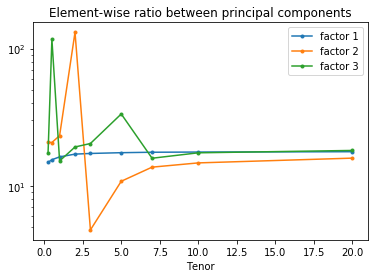

In [6]:
x_cov, v_cov = np.linalg.eig(cov) # covariance 
pct_cov = np.cumsum(x_cov)/sum(x_cov)*100

x_cor, v_cor = np.linalg.eig(cor) # covariance 
pct_cor = np.cumsum(x_cor)/sum(x_cor)*100

sigma = np.sqrt(np.diag(cov))
v_2 = np.array([v*sigma for v in v_cor.T]).T

semilogy(tenors, np.abs((v_cov/v_2))[:, :3], '.-');
xlabel('Tenor');
title('Element-wise ratio between principal components');
legend(['factor %d' % i for i in range(1, 4)]);

3: the cumulative percentage of variance explained by the covariance matrix PCA factors are show below. It takes 3 PCA factors to explain 95% of the changes.

In [7]:
pct_df = pd.DataFrame(pct_cov, index=['Factor %d' % (i+1) for i in range(len(tenors))], 
                      columns=['% explained']).T
fmt.displayDF(pct_df)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
% explained,77.5651,91.4014,95.8548,97.5993,98.4263,99.0452,99.4451,99.7063,100.0000


4: The first 3 principal components, they have the standard interpretatio of level, slope and curvature changes.

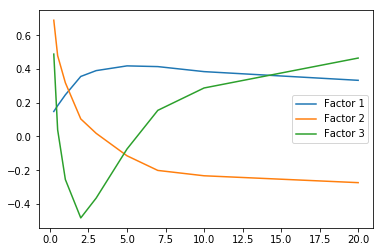

In [8]:
plot(tenors, v_cov[:, :3])
legend(['Factor 1', 'Factor 2', 'Factor 3'], loc='best');

5: the factor loading history of changes to the first 3 principal components:

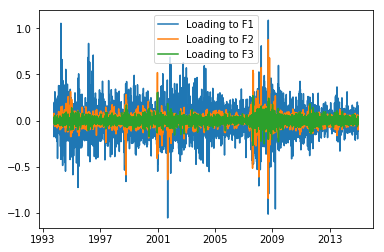

In [9]:
fl = dr.dot(v_cov[:, :3])
plot(fl)
legend(['Loading to F1', 'Loading to F2', 'Loading to F3']);

6: The following are the original and the simulated covariance matrix from the first 3 principal components with 1000 paths. They look very similar to each other. A good metric to measure the difference of matrix is the ratio of the L-2 norm of the diff matrix over that of the original matrix, ie, $\frac{\Vert A - B \Vert_2}{\Vert A \Vert_2}$, which is the relative version of the root mean square (RMS) error. This ratio is only 2% in this example, showing the first 3 principal component adquately capture the full covariance matrix of changes.

In [10]:
def sim_paths(pcs, eigv, periods, n) :
    es = np.random.normal(size=[n, periods, len(eigv)])
    sigmas = np.sqrt(eigv)
    adj_pcs = np.array([pc*sigma for pc, sigma in zip(pcs.T, sigmas)]).T
    
    return np.array([[adj_pcs.dot(e) for e in ep] for ep in es])
        
nf = 3
periods = 250*20
npath = 1000
simp = sim_paths(v_cov[:,:nf], x_cov[:nf], periods, npath)
cov_sim = pd.DataFrame(np.cov(np.vstack(simp).T), columns=cov.index, index=cov.index)
fmt.displayDFs(cov, headers=['Original covariance matrix'])
fmt.displayDFs(cov_sim, headers=['Simulated covariance matrix'])

print("L-2 norm ratio of the diff/original covar matrix: %3g" \
 % (np.linalg.norm(cov-cov_sim, 2)/np.linalg.norm(cov, 2)))

L-2 norm ratio of the diff/original covar matrix: 0.02249


7: we take a flat term structure of 3% as the starting point (any resonable choices will do here). The simulated 5Y IR level is simply the sum of daily changes and the initial term structure. 

In [11]:
terminal_levels = np.cumsum(simp, 1) + 3

u = np.mean(terminal_levels, 0)
s = np.std(terminal_levels, 0)
q2 = np.percentile(terminal_levels, 2, axis=0)
q98 = np.percentile(terminal_levels, 98, axis=0)

metrics = np.array([u, s, q2, q98])

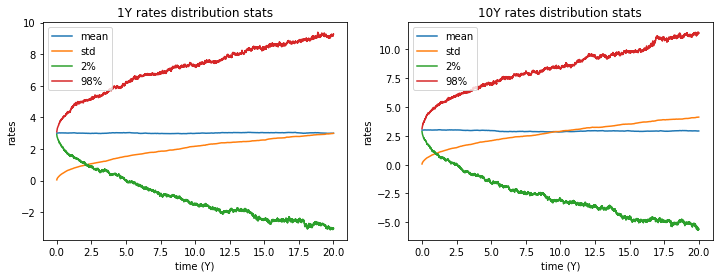

In [12]:
figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(np.arange(1, periods+1)/250., metrics[:, :, 2].T)
legend(['mean', 'std', '2%', '98%'], loc='best')
title('1Y rates distribution stats')
ylabel('rates')
xlabel('time (Y)');

subplot(1, 2, 2)
plot(np.arange(1, periods+1)/250., metrics[:, :, 7].T)
legend(['mean', 'std', '2%', '98%'], loc='best')
title('10Y rates distribution stats')
ylabel('rates')
xlabel('time (Y)');

8: Historical quantiles of all tenors are shown below. It is clear that the historical 2% and 98% are within [0, 8], that is very different from the simulation results at the far future.

In [13]:
pct_2 = np.percentile(cmt_rates, 2, axis=0)
pct_98 = np.percentile(cmt_rates, 98, axis=0)

pd_pct = pd.DataFrame(np.array([pct_2, pct_98]), columns = cov.index, index=['2nd %ile', '98th %ile'])

pd_pct

/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,0.25,0.5,1,2,3,5,7,10,20
2nd %ile,nan,0.05,0.1,0.24,0.35,0.71,1.122,1.71,2.45
98th %ile,nan,6.338,6.37,6.798,6.92,7.2,7.338,7.44,7.775


9: the standard deviation and the 98%-2% envelope of the simulated IR rates levels keeps increasing, which is not realistic. In reality, the rates are range bounded. The problem lies in the assumption that the changes are independent, which did not capture the mean reversion of the interest rates.  Applying the PCA on levels are a better choice, because we can capture the mean reversion by fitting a mean reversion process to the historical time series of the projections to the first few principal components. It is much harder to introduce mean reversion if the PCA analysis is done to the changes. The PCA on IR changes is only suitable if the application's time horizon is short, like the daily rebalancing of hedges. 